In [3]:
import torch
import torchvision
import time
import random
import math
import json

from PIL import Image, ImageFont, ImageDraw

In [4]:
im = Image.open('./Test_Pictures/A_rhodesian-ridgeback.jpg')
To_Tensor = torchvision.transforms.ToTensor()
tensor_dog = To_Tensor(im).unsqueeze(0)
print(tensor_dog.shape)

torch.Size([1, 3, 619, 1100])


In [5]:
"""
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT,
    box_detections_per_img=100
)
model.train()
"""

'\nmodel = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(\n    weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT,\n    box_detections_per_img=100\n)\nmodel.train()\n'

In [6]:
#print(model.cpu()(tensor_dog))
#print(model.cpu()(tensor_dog,[{'boxes':torch.FloatTensor([[0,0,10,10]]), 'labels':torch.zeros(1).long()}]))

In [7]:
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
targets = [
    {'boxes':torch.FloatTensor([[0,0],[0,0]]), 'labels':torch.LongTensor([1,0,0,0])}
]

In [8]:
def displayCoords(image, coords):
    imageCopy = image.copy()
    draw = ImageDraw.Draw(imageCopy)
    for coord in coords:
        x1 = coord[0]
        y1 = coord[1]
        x2 = coord[2]
        y2 = coord[3]
        
        draw.rectangle([x1,y1,x2,y2], outline=(0,0,0), width=2)
        
    display(imageCopy)

In [14]:
def createImage(pixelSize=(600,600), symbols=[], font=None, yBaseOffset=0,angle=0,seed=0) -> Image:
    random.seed(seed)
    
    info = {'boxes' : [], 'labels' : []}
    
    if font == None:
        font = ImageFont.truetype("meiryo.ttc", 40)
        
    padding = 5
    
    foreground=(random.randrange(256),random.randrange(256),random.randrange(256), 255)
    background=(random.randrange(256),random.randrange(256),random.randrange(256))
    
    distance = abs(foreground[0]+foreground[1]+foreground[2]-background[0]-background[1]-background[2])
    modif = 255//(distance+1)
    background=(background[0]*modif,background[1]*modif,background[2]*modif)
    
    baseFontSize = font.size
    
    image1 = Image.new(mode='RGBA', size=pixelSize, color=(255,255,255,0))
    background1 = Image.new(mode='RGB', size=pixelSize, color=background)
    
    draw1 = ImageDraw.Draw(image1)
    
    for symbol in symbols:
        x0,y0,width,height = font.getbbox(symbol)
        
        fontSize = baseFontSize
        randXOffset = random.randrange(pixelSize[0] - fontSize)
        randYOffset = random.randrange(pixelSize[1] - fontSize)
        fontOffsetX = randXOffset
        fontOffsetY = yBaseOffset*fontSize + randYOffset
        draw1.text((fontOffsetX,fontOffsetY), symbol, foreground, font=font)
        info['boxes'].append([
            randXOffset-padding, 
            fontOffsetY-padding, 
            randXOffset+width+padding, 
            fontOffsetY+height+padding
        ])
    
    
    sampling = Image.Resampling.BICUBIC
    
    image_rot = background1.copy()
    image_rot.paste(image1.rotate(angle,sampling), (0, 0), image1.rotate(angle,sampling).split()[-1])
    
    #image_rot.show()
    return image_rot, info

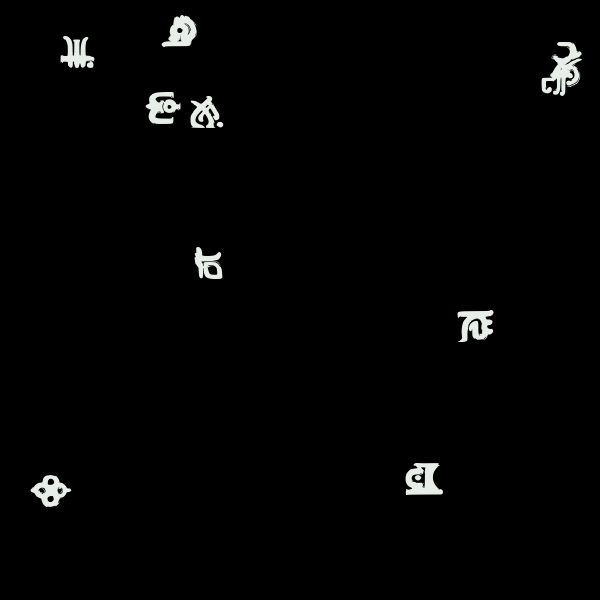

In [15]:
img_test,_ = createImage(
    symbols=alphabet[:10],
    font=ImageFont.truetype("./Fonts/SoulGlyph.ttf", 40),
    seed=11
)

display(img_test)

#img_test.save("./Test_Pictures/Test1.jpeg")

In [16]:
def createTrainingSet():
    
    start = time.time()
    nb_images = 1000
    list_info = []
    for i in range(nb_images):
        random.seed(420+i)
        pixelSize = (random.randrange(300,600),random.randrange(300,600))
        fontSize = random.randrange(30,60)
        nbSelected = random.randrange(4,13)
        labels = [random.randrange(0,26) for i in range(nbSelected)]
        letters = [alphabet[i] for i in labels]
        
        img, info = createImage(
            pixelSize=pixelSize,
            symbols=letters,
            font=ImageFont.truetype("./Fonts/SoulGlyph.ttf", 40),
            yBaseOffset=0.1,
            seed=i
        )
        
        info['labels'].extend(labels)
        info['image']="./Test_Pictures/Image_" + str(i) + ".jpeg"
        img.save(info['image'])
        list_info.append(info)
        
        if i%50==49:
            end = time.time()
            ratio = i/nb_images
            dt = end-start
            expected_time = math.floor(dt*((1-ratio)/ratio))

            percent = 100*ratio
            percent = math.floor(100*percent)/100
            print(str(percent)+"% of pictures generated. Estimated time left : " 
                  + str(expected_time//60) + "m " + str(expected_time%60) + "s")
            
    with open('targets.json', 'w', encoding="utf-8") as outfile:
        json.dump(list_info, outfile, indent=4)
            
    print("100% of pictures generated.")

In [17]:
createTrainingSet()

4.9% of pictures generated. Estimated time left : 0m 3s
9.9% of pictures generated. Estimated time left : 0m 3s
14.89% of pictures generated. Estimated time left : 0m 2s
19.9% of pictures generated. Estimated time left : 0m 2s
24.9% of pictures generated. Estimated time left : 0m 2s
29.9% of pictures generated. Estimated time left : 0m 2s
34.9% of pictures generated. Estimated time left : 0m 2s
39.9% of pictures generated. Estimated time left : 0m 1s
44.9% of pictures generated. Estimated time left : 0m 1s
49.9% of pictures generated. Estimated time left : 0m 1s
54.9% of pictures generated. Estimated time left : 0m 1s
59.9% of pictures generated. Estimated time left : 0m 1s
64.9% of pictures generated. Estimated time left : 0m 1s
69.89% of pictures generated. Estimated time left : 0m 1s
74.9% of pictures generated. Estimated time left : 0m 0s
79.9% of pictures generated. Estimated time left : 0m 0s
84.9% of pictures generated. Estimated time left : 0m 0s
89.9% of pictures generated. Es

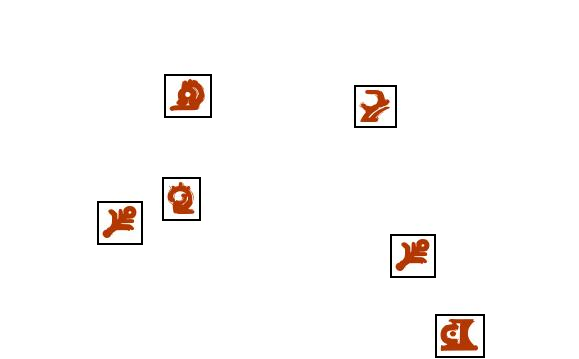

In [13]:
with open('targets.json', 'r', encoding="utf-8") as f:
    image_nb = 105
    infos = json.load(f)
    test_img = Image.open(infos[image_nb]['image'])
    displayCoords(test_img, infos[image_nb]['boxes'])
    